## EDA

Add in some additional columns and perform some EDA

In [7]:
# Uncomment to get the correct versions
from IPython.display import clear_output
!pip install -r ../requirements.txt
clear_output() 


In [8]:
import pandas as pd
import altair as alt
pd.set_option('display.max_columns', 500)

In [9]:
df = pd.read_csv('../data/M2_final.csv')
df.head()

,name,rating,ranking,year,position,height,weight,latitude,longitude,hometown_city,state_province,hometown_country,stars,committed_to,athlete_id,is_drafted,conference,latitude_school,longitude_school,school,season,wins_rolling_2year,games_played_rolling_2year,post_season_wins_rolling_2year,point_diff_rolling_2year,win_pct_rolling_2year
0,Dorial Green-Beckham,0.9997,1.0,2012,WR,78.0,220.0,37.216678,-93.292037,Springfield,MO,USA,5,Missouri,531380.0,1.0,SEC,38.935849,-92.333201,Missouri,2012.0,18.0,26.0,1.0,300.0,0.692308
1,Mario Edwards,0.9995,2.0,2012,DT,75.0,285.0,33.215039,-97.133052,Denton,TX,USA,5,Florida State,530290.0,1.0,ACC,30.438169,-84.304403,Florida State,2012.0,19.0,27.0,2.0,366.0,0.703704
2,D.J. Humphries,0.9979,3.0,2012,OT,77.0,275.0,35.227200,-80.843083,Charlotte,NC,USA,5,Florida,-1009881.0,1.0,SEC,29.649936,-82.348579,Florida,2012.0,15.0,26.0,2.0,178.0,0.576923
3,Shaq Thompson,0.9975,4.0,2012,S,74.0,210.0,38.581572,-121.494400,Sacramento,CA,USA,5,Washington,535329.0,1.0,Big Ten,47.650323,-122.301575,Washington,2012.0,14.0,26.0,1.0,-130.0,0.538462
4,Noah Spence,0.9974,5.0,2012,WDE,75.0,235.0,40.266311,-76.886112,Harrisburg,PA,USA,5,Ohio State,-1027150.0,1.0,Big Ten,40.001645,-83.019727,Ohio State,2012.0,18.0,26.0,1.0,363.0,0.692308


In [10]:
# Impute ranking with a regression using rating
# Impute hometown latitude / longitude with that state's average
# Impute height / weight with that position's mean
# Replace null positions and home state with 'unknown'

# School momentum data.
# in about 1% of records, we're missing data about the school's win total. 
# In spot checking records, it looks like it occurs in instances when a school is promoted from
# FCS to FBS teams. Let's impute their missing data based off the conference they're now apart of.  (like we did for hometown latitude / longitude coordinates). 

df.isna().sum() / len(df)

name                              0.000000
rating                            0.000000
ranking                           0.001587
year                              0.000000
position                          0.000000
height                            0.001253
weight                            0.001378
latitude                          0.007600
longitude                         0.007600
hometown_city                     0.004301
state_province                    0.004552
hometown_country                  0.001796
stars                             0.000000
committed_to                      0.000000
athlete_id                        0.140310
is_drafted                        0.000000
conference                        0.000000
latitude_school                   0.000000
longitude_school                  0.000000
school                            0.011358
season                            0.011358
wins_rolling_2year                0.014824
games_played_rolling_2year        0.014824
post_season

In [11]:
df.shape

(23947, 26)

In [12]:
def lat_long_imputation(data, group_by_col, missing_data_col, backup_replace_col):
    """
    This function imputes missing values by looking up the average value of the 
    missing column for a known categorical value. 

    For example, if a recruit has missing hometown coordinates, then we will 
    look up the average latitude / longitude for that recruit's state. 

    If the data is still missing after looking up missing values, then we'll fill with the column's mean. 

    args:
    data (dataframe): our dataframe
    group_by_col (string): the name of the column that we will use to look up the average (it would be the state in the example above).
    missing_data_col (string): the column that has missing data we're trying to impute.
    backup_replace_col (string): if still missing values, this is the value in the dataset we replace missing ones with. 
    """

    # Create look-up table to get average for that value. 
    lookup_df = data.groupby(by = group_by_col).agg({missing_data_col: 'max'}).reset_index()
    
    # join to lookup table to get the missing value
    data = pd.merge(left = data, right = lookup_df, how = 'left', on = group_by_col, suffixes = ('', '_imputed'))
    
    # Fill with lookup table's value
    data[missing_data_col] = data[missing_data_col].fillna(data[missing_data_col])

    # If still null fill in with another column
    data[missing_data_col] = data[missing_data_col].fillna(data[backup_replace_col])

    # If STILL null, fill with missing column median
    data[missing_data_col] = data[missing_data_col].fillna(data[missing_data_col].median())
    
    # Drop columns used for imputation
    data = data.drop(columns = missing_data_col + '_imputed')
    
    return data

df = lat_long_imputation(df, 'state_province', 'latitude', 'latitude_school')
df = lat_long_imputation(df, 'state_province', 'longitude', 'longitude_school')

In [13]:
def height_weight_imputation(data, group_by_col, missing_data_col):
    """
    This function imputes missing values by looking up the average value of the 
    missing column for a known categorical value. 

    For example, if a recruit has missing height or weight, then we will 
    look up the average height/weight for that recruit's position. 

    If the data is still missing after looking up missing values, then we'll fill with the column's mean. 

    args:
    data (dataframe): our dataframe
    group_by_col (string): the name of the column that we will use to look up the average (it would be the state in the example above).
    missing_data_col (string): the column that has missing data we're trying to impute.
    """

    # Create look-up table to get average for that value. 
    lookup_df = data.groupby(by = group_by_col).agg({missing_data_col: 'max'}).reset_index()
    
    # join to lookup table to get the missing value
    data = pd.merge(left = data, right = lookup_df, how = 'left', on = group_by_col, suffixes = ('', '_imputed'))
    
    # fill with imputed amount
    data[missing_data_col] = data[missing_data_col].fillna(data[missing_data_col + '_imputed'])

    # If STILL null, fill with missing column median
    data[missing_data_col] = data[missing_data_col].fillna(data[missing_data_col].median())
    
    # Drop columns used for imputation
    data = data.drop(columns = missing_data_col + '_imputed')
    
    return data


df = height_weight_imputation(df, 'position', 'height')
df = height_weight_imputation(df, 'position', 'weight')    

In [14]:
def season_momentum_imputation(data, group_by_col, missing_data_col):
    """
    This function imputes missing values by looking up the average value of the 
    missing column for a known categorical value. 

    For example, if a recruit's team has a missing win %, then we will 
    look up the average win % for that team's conference.

    This only occurs in about 1.5% of records.

    args:
    data (dataframe): our dataframe
    group_by_col (string): the name of the column that we will use to look up the average (it would be the state in the example above).
    missing_data_col (string): the column that has missing data we're trying to impute.
    """

    # Create look-up table to get average for that value. 
    lookup_df = data.groupby(by = group_by_col).agg({missing_data_col: 'max'}).reset_index()
    
    # join to lookup table to get the missing value
    data = pd.merge(left = data, right = lookup_df, how = 'left', on = group_by_col, suffixes = ('', '_imputed'))
    
    # fill with imputed amount
    data[missing_data_col] = data[missing_data_col].fillna(data[missing_data_col + '_imputed'])

    # If STILL null, fill with missing column median
    data[missing_data_col] = data[missing_data_col].fillna(data[missing_data_col].median())
    
    # Drop columns used for imputation
    data = data.drop(columns = missing_data_col + '_imputed')
    
    return data


df = season_momentum_imputation(df, 'conference', 'wins_rolling_2year')
df = season_momentum_imputation(df, 'conference', 'games_played_rolling_2year')
df = season_momentum_imputation(df, 'conference', 'post_season_wins_rolling_2year')
df = season_momentum_imputation(df, 'conference', 'point_diff_rolling_2year')
df = season_momentum_imputation(df, 'conference', 'win_pct_rolling_2year')

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def lin_reg_imputation(data, x_col, pred_col):

    # Separate the rows where the target column has missing values
    missing_values = data[data[pred_col].isnull()]
    non_missing_values = data.dropna(subset=[pred_col, x_col])
    
    # Train a linear regression model
    X_train = non_missing_values[[x_col]]
    y_train = non_missing_values[pred_col]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_missing = missing_values[[x_col]]
    data.loc[data[pred_col].isnull(), pred_col] = model.predict(X_missing)
    
    return data

df = lin_reg_imputation(df, 'rating', 'ranking')

In [16]:
# The 2020 class may still be playing college football (hence the lower draft rate).
# They would be grad sutdents or RS Seniors this year... we should drop the 2020 cohort. 
df.groupby(by = 'year').agg({'is_drafted' : 'mean', 'year': 'count'})

,is_drafted,year
year,,
2012,0.086566,2449
2013,0.090482,2553
2014,0.088955,2698
2015,0.084387,2690
2016,0.097838,2729
2017,0.096660,2814
2018,0.088645,2730
2019,0.080045,2661
2020,0.052230,2623


In [17]:
# These columns are either redundant (school, season) or unnecessary since 
# the signal is captured elsewehre (like in state_province is captured by hometown coordinates)
df = df.drop(columns = ['school', 'season'])

In [18]:
df.isna().sum()

name                                 0
rating                               0
ranking                              0
year                                 0
position                             0
height                               0
weight                               0
latitude                             0
longitude                            0
hometown_city                      103
state_province                     109
hometown_country                    43
stars                                0
committed_to                         0
athlete_id                        3360
is_drafted                           0
conference                           0
latitude_school                      0
longitude_school                     0
wins_rolling_2year                   0
games_played_rolling_2year           0
post_season_wins_rolling_2year       0
point_diff_rolling_2year             0
win_pct_rolling_2year                0
dtype: int64

### Feature engineering:
1) calculate distance (in miles) between hometown and school
2) Create a feautre showing what side of the ball they play (offense, defense, etc.)
3) create a feature showing what position group they're in (o-line, d-back, etc.)

In [19]:
import pandas as pd
import numpy as np

# Function to calculate distance between two sets of coordinates taken from this stack overflow post:
# https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

# Function to calculate distance between hometown and school (in miles)
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    R = 3958.8
    
    # Convert degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    return distance

# Apply the function to the DataFrame
df['distance_miles'] = df.apply(lambda row: haversine(row['latitude'], row['longitude'], row['latitude_school'], row['longitude_school']), axis=1)

In [20]:
# feature engineering...
position_off_def_dict = {'DT': 'defense', 'ATH': 'athlete', 'OLB': 'defense', 'SDE': 'defense'
                       , 'WDE': 'defense', 'S': 'defense', 'CB': 'defense'
                       , 'TE': 'offense', 'OT': 'offense', 'WR': 'offense'
                       , 'ILB': 'defense', 'OG': 'offense', 'PRO': 'offense'
                       , 'K': 'special', 'RB': 'offense', 'P': 'special', 'DUAL': 'offense', 'APB': 'offense'
                       , 'OC': 'defense', 'DL': 'defense', 'EDGE': 'defense', 'IOL': 'offense'
                       , 'LB': 'defense', 'QB': 'offense', 'FB': 'offense', 'LS': 'special', 'nan': 'unknown'}

df["side_of_ball"] = df["position"].map(position_off_def_dict)

position_group_dict = {'DT': 'd_line', 'ATH': 'athlete', 'OLB': 'linebacker', 'SDE': 'd_line'
                       , 'WDE': 'd_line', 'S': 'd_backfield', 'CB': 'd_backfield'
                       , 'TE': 'pass_catcher', 'OT': 'o_line', 'WR': 'pass_catcher'
                       , 'ILB': 'linebacker', 'OG': 'o_line', 'PRO': 'qb'
                       , 'K': 'special', 'RB': 'running_back', 'P': 'special', 'DUAL': 'qb', 'APB': 'running_back'
                       , 'OC': 'd_line', 'DL': 'd_line', 'EDGE': 'd_line', 'IOL': 'o_line'
                       , 'LB': 'linebacker', 'QB': 'qb', 'FB': 'running_back', 'LS': 'special'}

df["position_group"] = df["position"].map(position_group_dict)

In [21]:
def fill_col_unknown(data, unknown_col_name):
    data[unknown_col_name] = data[unknown_col_name].fillna('unknown')

    return data

data = fill_col_unknown(df, 'position')
data = fill_col_unknown(df, 'side_of_ball')
data = fill_col_unknown(df, 'position_group')

### Final EDA

In [22]:
print("Basic Info:")
print(df.info())  # Gives an overview of the dataset


Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23947 entries, 0 to 23946
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            23947 non-null  object 
 1   rating                          23947 non-null  float64
 2   ranking                         23947 non-null  float64
 3   year                            23947 non-null  int64  
 4   position                        23947 non-null  object 
 5   height                          23947 non-null  float64
 6   weight                          23947 non-null  float64
 7   latitude                        23947 non-null  float64
 8   longitude                       23947 non-null  float64
 9   hometown_city                   23844 non-null  object 
 10  state_province                  23838 non-null  object 
 11  hometown_country                23904 non-null  object 
 12  stars               

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,23947.0,8.321575e-01,5.645274e-02,6.063000e-01,0.790300,8.305000e-01,8.628000e-01,1.000000e+00
ranking,23947.0,1.550716e+03,1.037481e+03,1.000000e+00,664.000000,1.414000e+03,2.345000e+03,4.259000e+03
year,23947.0,2.016050e+03,2.546101e+00,2.012000e+03,2014.000000,2.016000e+03,2.018000e+03,2.020000e+03
height,23947.0,7.395792e+01,2.511385e+00,6.100000e+01,72.000000,7.400000e+01,7.600000e+01,8.300000e+01
weight,23947.0,2.201616e+02,4.521299e+01,2.700000e+01,185.000000,2.100000e+02,2.500000e+02,2.000000e+03
latitude,23947.0,3.484045e+01,5.312837e+00,-1.427548e+01,31.149953,3.402332e+01,3.917316e+01,6.518869e+01
longitude,23947.0,-9.137017e+01,1.508005e+01,-1.707048e+02,-96.670550,-8.644759e+01,-8.165565e+01,1.313497e+02
stars,23947.0,2.857644e+00,6.752880e-01,1.000000e+00,2.000000,3.000000e+00,3.000000e+00,5.000000e+00
athlete_id,20587.0,2.691604e+06,2.201564e+06,-1.044268e+06,545254.500000,4.035761e+06,4.371890e+06,4.708407e+06
is_drafted,23947.0,8.522988e-02,2.792293e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


In [24]:
quant_cols = list(df.describe().columns)

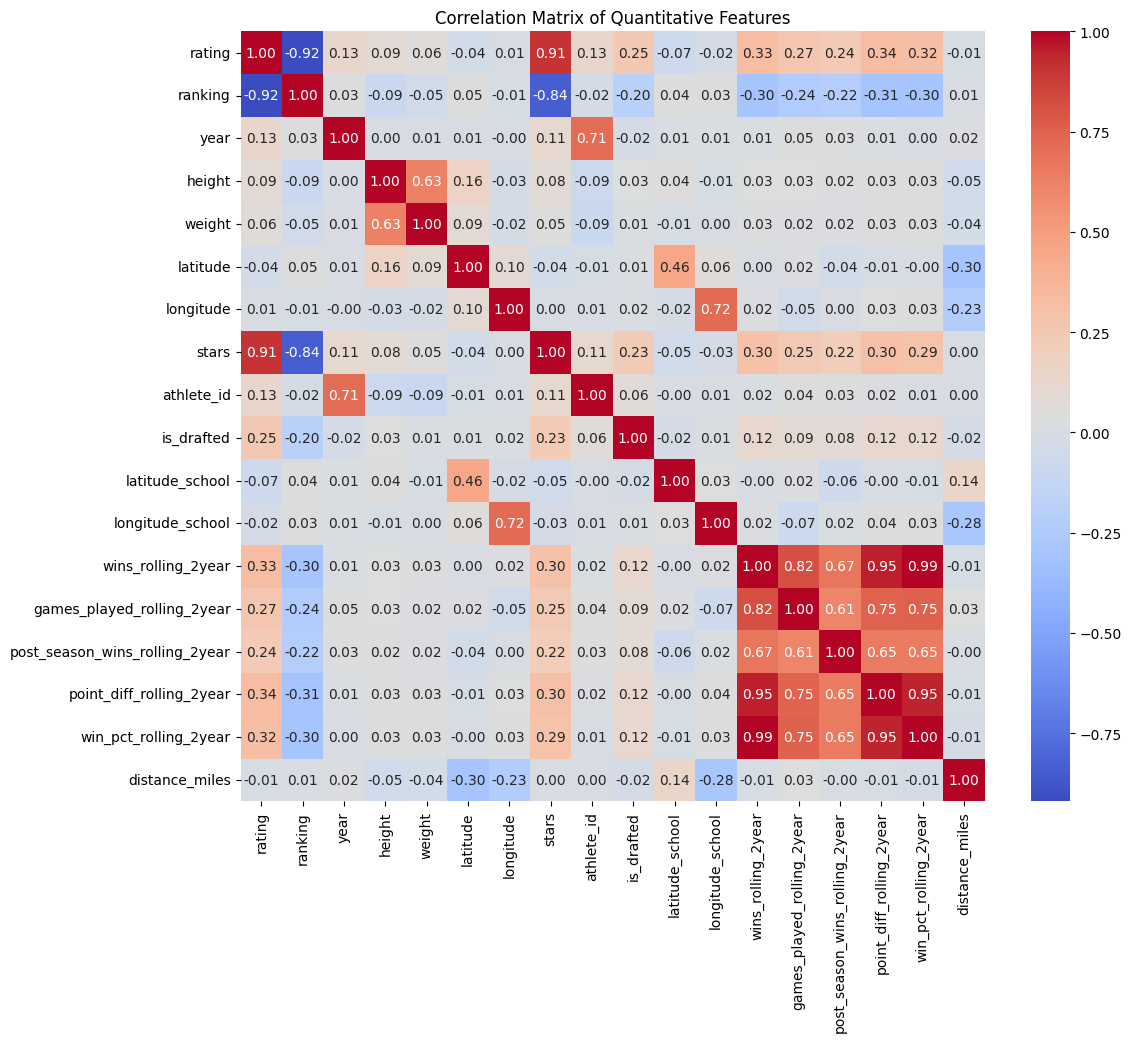

In [25]:
# Correlation Matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_correlation(df):
    """Plot the correlation matrix for numerical features"""
    plot_df = df[quant_cols]
    plt.figure(figsize=(12, 10))
    sns.heatmap(plot_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Quantitative Features')
    plt.show()

plot_correlation(df)

In [26]:
# ! pip install plotly
import pandas as pd
import plotly.express as px

# Heatmatp of recruits by home town
fig = px.density_mapbox(df, lat = 'latitude', lon = 'longitude',
                        radius = 40,
                        center = dict(lat = 39, lon = -98),
                        zoom = 3.5,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        # title = 'Heatmap of where 4 Star Recruits are From',
                        range_color = [0, 100])
#fig.write_image('recruit_home.png', auto_open=True)

fig.update_layout(
        title_text = 'Distribution of Football Recruiting Talent by Hometown Location',
        showlegend = True,
        # autosize = True,
        width = 1200,
        height = 700,
        margin_autoexpand = True,
        margin=dict(l=20, r=20, t=70, b=20),
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
        
    )
# fig.write_image('recruits_school.png')

fig.show()

In [27]:
import pandas as pd
import plotly.express as px

# Heatmatp of recruits by home town
fig = px.density_mapbox(df, lat = 'latitude_school', lon = 'longitude_school',
                        radius = 40,
                        center = dict(lat = 39, lon = -98),
                        zoom = 3.5,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        # title = 'Heatmap of where 4 Star Recruits are From',
                        range_color = [0, 100])
#fig.write_image('recruit_home.png', auto_open=True)

fig.update_layout(
        title_text = 'Distribution of Football Recruiting Talent by Hometown Location',
        showlegend = True,
        # autosize = True,
        width = 1200,
        height = 700,
        margin_autoexpand = True,
        margin=dict(l=20, r=20, t=70, b=20),
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
        
    )
# fig.write_image('recruits_school.png')

fig.show()

In [28]:
df[['state_province', 'hometown_country']].value_counts() 

state_province  hometown_country
TX              USA                 3415
FL              USA                 3148
CA              USA                 2219
GA              USA                 2038
OH              USA                 1215
                                    ... 
EN              England                1
NR              Germany                1
QL              AUS                    1
VC              AUS                    1
UK              England                1
Name: count, Length: 61, dtype: int64

In [29]:
import seaborn as sns 
import matplotlib.pyplot as plt

df_test= sns.load_dataset('tips')
df_test.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [36]:
df.head() 

,name,rating,ranking,year,position,height,weight,latitude,longitude,hometown_city,state_province,hometown_country,stars,committed_to,athlete_id,is_drafted,conference,latitude_school,longitude_school,wins_rolling_2year,games_played_rolling_2year,post_season_wins_rolling_2year,point_diff_rolling_2year,win_pct_rolling_2year,distance_miles,side_of_ball,position_group
0,Dorial Green-Beckham,0.9997,1.0,2012,WR,78.0,220.0,37.216678,-93.292037,Springfield,MO,USA,5,Missouri,531380.0,1.0,SEC,38.935849,-92.333201,18.0,26.0,1.0,300.0,0.692308,129.726375,offense,pass_catcher
1,Mario Edwards,0.9995,2.0,2012,DT,75.0,285.0,33.215039,-97.133052,Denton,TX,USA,5,Florida State,530290.0,1.0,ACC,30.438169,-84.304403,19.0,27.0,2.0,366.0,0.703704,776.590432,defense,d_line
2,D.J. Humphries,0.9979,3.0,2012,OT,77.0,275.0,35.227200,-80.843083,Charlotte,NC,USA,5,Florida,-1009881.0,1.0,SEC,29.649936,-82.348579,15.0,26.0,2.0,178.0,0.576923,395.212334,offense,o_line
3,Shaq Thompson,0.9975,4.0,2012,S,74.0,210.0,38.581572,-121.494400,Sacramento,CA,USA,5,Washington,535329.0,1.0,Big Ten,47.650323,-122.301575,14.0,26.0,1.0,-130.0,0.538462,627.908306,defense,d_backfield
4,Noah Spence,0.9974,5.0,2012,WDE,75.0,235.0,40.266311,-76.886112,Harrisburg,PA,USA,5,Ohio State,-1027150.0,1.0,Big Ten,40.001645,-83.019727,18.0,26.0,1.0,363.0,0.692308,324.459618,defense,d_line


In [39]:
df['state_country'] = df['state_province'] + ', ' + df['hometown_country']


/var/folders/wp/393dmtxd2jd8sj2z2tt7jpm40000gn/T/ipykernel_80631/1586748687.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




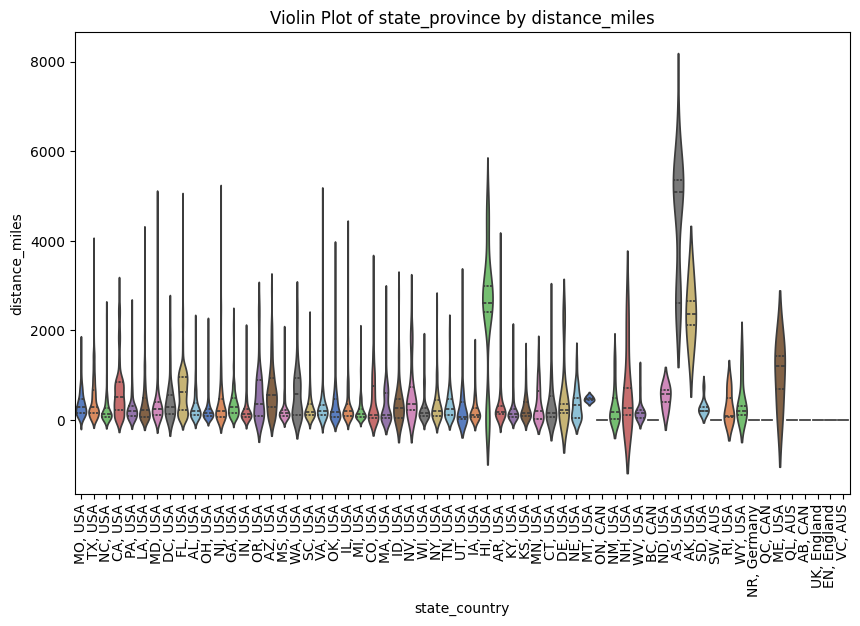

In [48]:
# Numerical values 
numerical_features  = ['height', 'weight', 'distance_miles']

plt.figure(figsize=(10, 6))
# sns.violinplot(x='height', y='weight', data=df, inner='quartile', palette="muted")
sns.violinplot(x='state_country', y='distance_miles',data=df, inner='quartile', palette="muted")

# Add labels and title
plt.title('Violin Plot of state_province by distance_miles')
plt.xlabel('state_country')
plt.xticks(rotation=90)

plt.ylabel('distance_miles')
plt.show()



In [31]:
df.to_csv('../data/imputed_dataset.csv', index = False)